## 1. investing.com 크롤링으로 미국 기준금리를 가져오자

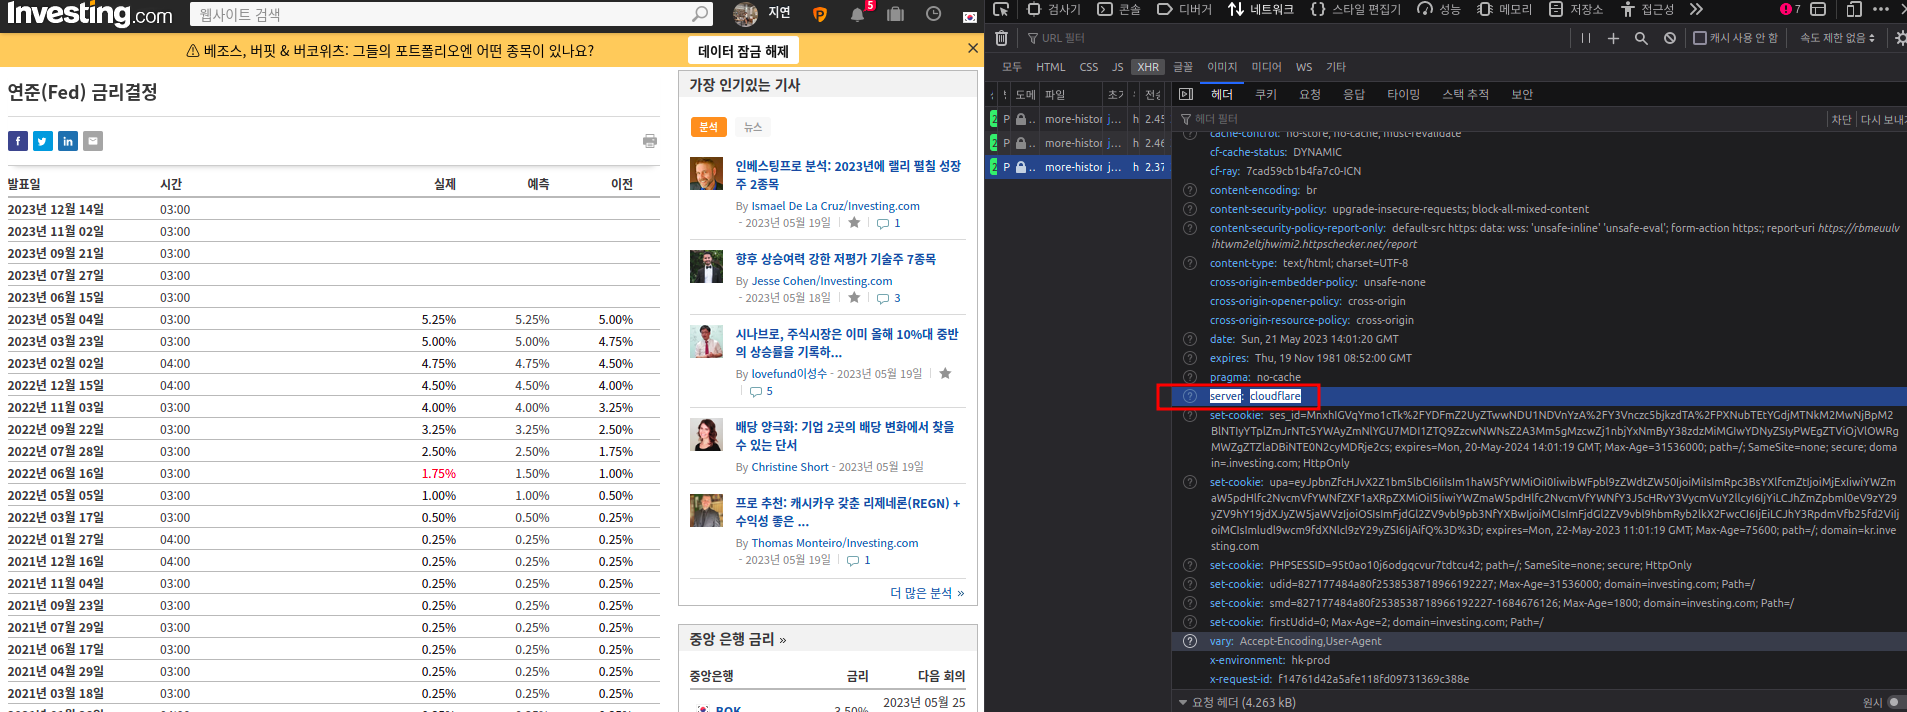

서버가 cloudflare(네트워크 보안회사)의 보호를 받고 있음  

- DNS(Domain Name System)는 도메인 이름을 IP 주소로 변환함
- CDN(Contents Delivery Network)는 인터넷(Internet) 사용 환경에서 게임 클라이언트(Client)나 콘텐츠(Contents)를 사용자의 PC로 효율적으로 전달하기 위해 분산된 서버(Server)에 데이터(Data)를 저장해 전달해주는 시스템(System)

In [24]:
from bs4 import BeautifulSoup
import cloudscraper # cloudflare 때문에 requests 사용이 불가하므로, 대체할 수 있는 라이브러리

url = ('https://kr.investing.com/economic-calendar/interest-rate-decision-168')
scraper = cloudscraper.create_scraper() # returns a CloudScraper instance
# Or: scraper = cloudscraper.CloudScraper() # CloudScraper inherits from requests.Session
# html = scraper.get(url).content
html = scraper.get(url).text
soup = BeautifulSoup(html, 'lxml')

table = soup.select('#eventHistoryTable168 tbody tr')
table

td = soup.select('#eventHistoryTable168 tr > td:nth-child(1)')
span = soup.select('#eventHistoryTable168 tbody tr td span')

# table
td, span

([<td class="left">2023년 12월 14일 </td>,
  <td class="left">2023년 11월 02일 </td>,
  <td class="left">2023년 09월 21일 </td>,
  <td class="left">2023년 07월 27일 </td>,
  <td class="left">2023년 06월 15일 </td>,
  <td class="left">2023년 05월 04일 </td>],
 [<span class="blackFont" title=""> </span>,
  <span class="blackFont" title=""> </span>,
  <span class="blackFont" title=""> </span>,
  <span class="blackFont" title=""> </span>,
  <span class="blackFont" title=""> </span>,
  <span class="blackFont" title="기대치에 따라">5.25%</span>])

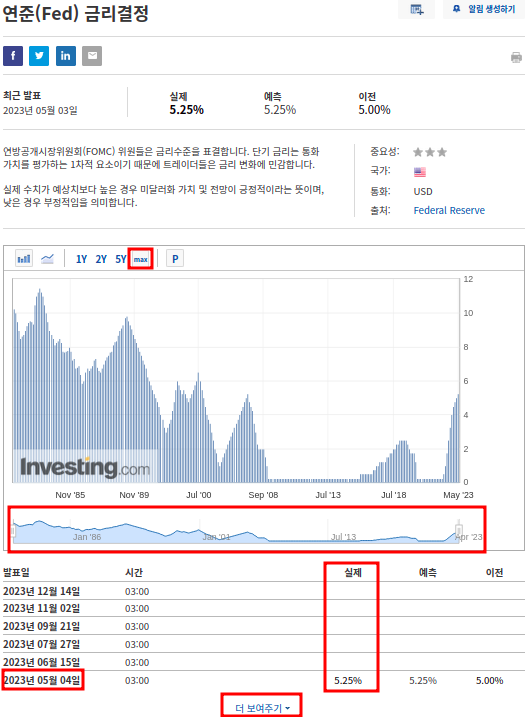

음... 더보기를 눌러서 2000년부터 최근까지의 데이터를 가져와야 하는데 만만치 않네!

### 1차 시도

In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import cloudscraper

url = 'https://kr.investing.com/economic-calendar/interest-rate-decision-168'

scraper = cloudscraper.create_scraper() # returns a CloudScraper instance

html = scraper.get(url).text
soup = BeautifulSoup(html, 'lxml')

table = pd.read_html(str(soup))

# table = soup.select("table")
# table = pd.read_html(str(table))

table[0]

,발표일,시간,실제,예측,이전,Unnamed: 5
0,2023년 12월 14일,03:00,NaN,NaN,NaN,NaN
1,2023년 11월 02일,03:00,NaN,NaN,NaN,NaN
2,2023년 09월 21일,03:00,NaN,NaN,NaN,NaN
3,2023년 07월 27일,03:00,NaN,NaN,NaN,NaN
4,2023년 06월 15일,03:00,NaN,NaN,NaN,NaN
5,2023년 05월 04일,03:00,5.25%,5.25%,5.00%,NaN


### 2차 시도

In [89]:
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException, ElementNotInteractableException, TimeoutException, InvalidSessionIdException

ig_e = (NoSuchElementException, StaleElementReferenceException,)

url = 'https://kr.investing.com/economic-calendar/interest-rate-decision-168'

chrome_options = wd.ChromeOptions()
chrome_options.add_argument("--incognito") # 시크릿 모드
chrome_options.add_argument("--no-sandbox") # Bypass OS security model ***** 최소 옵션
chrome_options.add_argument("--lang=ko_KR") # 한국어 설정
chrome_options.add_argument("--start-maximized") # open Browser in maximized mode
chrome_options.add_argument("--disable-infobars") # disabling infobars
chrome_options.add_argument("--disable-extensions") # disabling extensions
chrome_options.add_argument("--disable-dev-shm-usage") # overcome limited resource problems. 메모리가 부족해서 에러가 발생하는 것을 막아줌 ***** 최소 옵션
chrome_options.add_argument("--disable-setuid-sandbox") # 크롬 드라이버에 setuid를 하지 않음으로써 크롬의 충돌을 막아줌
chrome_options.add_argument("--remote-debugging-port=9222") # 실행된 크롬창을 사용하도록 지정 (원격 디버깅 설정)
chrome_options.add_argument("user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36") # 사람인 척 하기

driver = wd.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options) # Selenium 4 버전 대
driver.get(url)
driver.implicitly_wait(3) # 처음 접속 시 대기(페이지 로딩 끝나면 진행)

try:
        for i in range(66): # FFTRUL 1982년 09월 28일~
                elem = WebDriverWait(driver, 5, ignored_exceptions=ig_e)\
                        .until(EC.element_to_be_clickable((By.XPATH, '/html/body/div[5]/section/div[12]/div[1]'))) # '더 보여주기' 클릭
                elem.click()
                driver.implicitly_wait(2)

except ElementNotInteractableException:
        print(f"{i}번째 클릭에서 끝")

except TimeoutException:
        print(f"{i}번째 클릭에서 끝")

except InvalidSessionIdException:
        print(f"{i}번째 클릭에서 끝")

finally:
        driver.close()

dates = driver.find_elements(By.CSS_SELECTOR, '#eventHistoryTable168 > tbody tr td:nth-child(1)') # 발표일 엘리먼트
dates = [date.text for date in dates]
rates = driver.find_elements(By.CSS_SELECTOR, '#eventHistoryTable168 > tbody tr td:nth-child(3) > span:nth-child(1)') # 실제 기준금리 엘리먼트
rates = [rate.text for rate in rates]

df = pd.DataFrame(columns=['dates', 'rates'])

df['dates'] = dates
df['rates'] = rates

df['rates'] = df['rates'].apply(lambda x: x.replace('%', ''))
df['rates'] = pd.to_numeric(df['rates'], errors='coerce') # 결측치가 있어 제거해주기 전에 미리 dtype 변환

df.dropna(subset=['rates'], axis=0, how='any', inplace=True)
df = df.reset_index(drop=True)

df.info()
df

61번째 클릭에서 끝
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   273 non-null    int64  
 1   dates   273 non-null    object 
 2   rates   273 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.5+ KB


In [121]:
FFTRUL = df

FFTRUL.rename(columns={'dates':'Date', 'rates':'Value'}, inplace=True)

FFTRUL

,Date,Value
0,2023년 05월 04일,5.25
1,2023년 03월 23일,5.00
2,2023년 02월 02일,4.75
3,2022년 12월 15일,4.50
4,2022년 11월 03일,4.00
...,...,...
268,1982년 12월 15일,8.50
269,1982년 11월 20일,9.00
270,1982년 10월 08일,9.50
271,1982년 10월 02일,10.00


In [101]:
import pandas as pd
from pandas_datareader import data as pdr # 데이터 로딩 및 시각화를 위한 라이브러리
import yfinance as yf # 금융 데이터 가져오는 Yahoo Finance
yf.pdr_override() # 둘이 합체!
from scipy import stats # 회귀 분석을 위한 수학, 과학, 엔지니어링용 핵심 패키지 모음(넘파이 기반)
import matplotlib.pylab as plt # 그래프 출력
from datetime import datetime
import os

kospi = pdr.get_data_yahoo('^KS11', '1983-01-04') # 발표시점은 1983-01-04부터이지만 1996-12-11부터 나온다.
kospi

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-12-11,705.989990,709.479980,704.429993,704.679993,704.679993,28000
1996-12-12,705.109985,706.010010,688.739990,689.380005,689.380005,25900
1996-12-13,690.440002,695.719971,677.640015,689.070007,689.070007,26500
1996-12-16,686.969971,686.969971,667.710022,673.919983,673.919983,22800
1996-12-17,675.349976,680.090027,660.390015,663.349976,663.349976,31600
...,...,...,...,...,...,...
2023-05-24,2557.110107,2572.209961,2555.040039,2567.449951,2567.449951,1071600
2023-05-25,2570.639893,2575.050049,2551.489990,2554.689941,2554.689941,916700
2023-05-26,2561.939941,2567.500000,2553.790039,2558.810059,2558.810059,631800


In [102]:
kospi = kospi.reset_index(drop=False) # 병합하기 위해 인덱스로 들어간 날짜를 컬럼으로 빼기
kospi

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-12-11,705.989990,709.479980,704.429993,704.679993,704.679993,28000
1,1996-12-12,705.109985,706.010010,688.739990,689.380005,689.380005,25900
2,1996-12-13,690.440002,695.719971,677.640015,689.070007,689.070007,26500
3,1996-12-16,686.969971,686.969971,667.710022,673.919983,673.919983,22800
4,1996-12-17,675.349976,680.090027,660.390015,663.349976,663.349976,31600
...,...,...,...,...,...,...,...
6519,2023-05-24,2557.110107,2572.209961,2555.040039,2567.449951,2567.449951,1071600
6520,2023-05-25,2570.639893,2575.050049,2551.489990,2554.689941,2554.689941,916700
6521,2023-05-26,2561.939941,2567.500000,2553.790039,2558.810059,2558.810059,631800
6522,2023-05-30,2582.409912,2586.219971,2574.820068,2585.520020,2585.520020,638500


In [127]:
print(type(kospi.loc[0, 'Date']))
print(type(FFTRUL.loc[0, 'Date']))

<class 'str'>
<class 'str'>


In [125]:
FFTRUL['Date'] = FFTRUL['Date'].apply(lambda x: x.replace('년 ', '-'))
FFTRUL['Date'] = FFTRUL['Date'].apply(lambda x: x.replace('월 ', '-'))
FFTRUL['Date'] = FFTRUL['Date'].apply(lambda x: x.replace('일', ''))

FFTRUL

,Date,Value
0,2023-05-04,5.25
1,2023-03-23,5.00
2,2023-02-02,4.75
3,2022-12-15,4.50
4,2022-11-03,4.00
...,...,...
268,1982-12-15,8.50
269,1982-11-20,9.00
270,1982-10-08,9.50
271,1982-10-02,10.00


In [126]:
kospi['Date'] = kospi['Date'].astype(str)

In [135]:
KOSPIFFTRUL = pd.merge(kospi, FFTRUL, how = 'left', left_on = 'Date', right_on = 'Date') # 날짜 교집합만 남기기 위해 kospi DF 기준으로 병합
# KOSPIFFTRUL = pd.concat([kospi, FFTRUL], axis=1, join='inner')

KOSPIFFTRUL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6524 entries, 0 to 6523
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6524 non-null   object 
 1   Open       6524 non-null   float64
 2   High       6524 non-null   float64
 3   Low        6524 non-null   float64
 4   Close      6524 non-null   float64
 5   Adj Close  6524 non-null   float64
 6   Volume     6524 non-null   int64  
 7   Value      161 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 458.7+ KB


In [136]:
FFTRUL = KOSPIFFTRUL[['Date', 'Value']] # 필요한 컬럼들만 가져오기
FFTRUL

,Date,Value
0,1996-12-11,NaN
1,1996-12-12,NaN
2,1996-12-13,NaN
3,1996-12-16,NaN
4,1996-12-17,NaN
...,...,...
6519,2023-05-24,NaN
6520,2023-05-25,NaN
6521,2023-05-26,NaN
6522,2023-05-30,NaN


In [138]:
FFTRUL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6524 entries, 0 to 6523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6524 non-null   object 
 1   Value   161 non-null    float64
dtypes: float64(1), object(1)
memory usage: 152.9+ KB


In [137]:
FFTRUL.isnull().sum()

Date        0
Value    6363
dtype: int64

In [139]:
6524 - 6363

161

In [141]:
FFTRUL = FFTRUL.fillna(method='ffill')
FFTRUL.isnull().sum()

Date      0
Value    69
dtype: int64

In [143]:
FFTRUL.loc[FFTRUL['Value'].isnull()]

,Date,Value
0,1996-12-11,NaN
1,1996-12-12,NaN
2,1996-12-13,NaN
3,1996-12-16,NaN
4,1996-12-17,NaN
...,...,...
64,1997-03-19,NaN
65,1997-03-20,NaN
66,1997-03-21,NaN
67,1997-03-24,NaN


In [144]:
FFTRUL = FFTRUL.fillna(method='bfill')
FFTRUL.isnull().sum()

Date     0
Value    0
dtype: int64

In [145]:
FFTRUL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6524 entries, 0 to 6523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6524 non-null   object 
 1   Value   6524 non-null   float64
dtypes: float64(1), object(1)
memory usage: 152.9+ KB


In [146]:
# Date 컬럼의 타입인 str을 Timestamp 타입으로 바꿔주고 인덱스로 빼기
FFTRUL['Date'] = pd.to_datetime(FFTRUL['Date']) # 'pandas._libs.tslibs.timestamps.Timestamp'
print(type(FFTRUL.loc[0, 'Date'])) # datetime64[ns]
FFTRUL.info()
FFTRUL.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6524 entries, 0 to 6523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6524 non-null   datetime64[ns]
 1   Value   6524 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 410.9 KB


,Date,Value
0,1996-12-11,5.5
1,1996-12-12,5.5
2,1996-12-13,5.5
3,1996-12-16,5.5
4,1996-12-17,5.5


In [147]:
FFTRUL.set_index('Date', inplace=True)
FFTRUL

,Value
Date,
1996-12-11,5.50
1996-12-12,5.50
1996-12-13,5.50
1996-12-16,5.50
1996-12-17,5.50
...,...
2023-05-24,5.25
2023-05-25,5.25
2023-05-26,5.25


In [152]:
import pandas as pd
from pandas_datareader import data as pdr # 데이터 로딩 및 시각화를 위한 라이브러리
import yfinance as yf # 금융 데이터 가져오는 Yahoo Finance
yf.pdr_override() # 둘이 합체!
from scipy import stats # 회귀 분석을 위한 수학, 과학, 엔지니어링용 핵심 패키지 모음(넘파이 기반)
import matplotlib.pylab as plt # 그래프 출력
from datetime import datetime, timedelta
import os

kospi = pdr.get_data_yahoo('^KS11', '1983-01-04') # KOSPI
yesterday = datetime.now().date() - timedelta(days=1)
workspace = os.getcwd() # 현재 작업 경로 확인

# Tickers on Yahoo Finance
symbols = {
    '^DJI': 'DOW Jones Industrial Average',
    'DX-Y.NYB': 'US Dollar Index',
    'KRW=X': 'US Dollar',
    'FFTRUL': 'Federal Funds Target Rate, Upper Limit',
}

def Regression(opponent:str='^DJI', filepath:str=workspace): # Regression 함수 선언
    """미국 기준금리/다우존스 지수/달러 인덱스/달러와 KOSPI 지수 사이의 상관관계를 확인하기 위한 회귀 그래프를 그려주는 함수\n
    opponent='종목 티커', filepath='그래프를 저장할 경로'를 매개변수로 받음"""

    if opponent == 'FFTRUL':
        versus = FFTRUL
        df = pd.DataFrame({'X':versus['Value'], 'Y':kospi['Close']}) # 가로축 독립변수 x: 미국 기준금리, 세로축 종속변수 y: KOSPI 지수
    else: 
        versus = pdr.get_data_yahoo(opponent, '1996-12-11')
        df = pd.DataFrame({'X':versus['Close'], 'Y':kospi['Close']}) # 가로축 독립변수 x: 다우존스 지수/달러 인덱스/달러, 세로축 종속변수 y: KOSPI 지수

    df = df.fillna(method='bfill') # 뒤의 값으로 결측치 대체
    df = df.fillna(method='ffill') # 마지막 행의 결측치를 앞의 값으로 대체

    regr = stats.linregress(df.X, df.Y) # 선형 회귀 모델 생성
    regr_line = f'Y = {regr.slope:.2f}  X + {regr.intercept:.2f}' # y의 기대치를 나타내는 회귀식. slope: 기울기, intercept: 절편

    plt.figure(figsize=(7, 7)) # 그래프 사이즈
    plt.plot(df.X, df.Y, '.') # X/Y의 좌표를 .으로 찍음 (Scatter Plot, 산점도)
    plt.plot(df.X, regr.slope * df.X + regr.intercept, 'r') # 회귀선을 붉은 선으로 그림
    
    plt.ylabel('KOSPI') # Y축은 KOSPI

    if opponent == '^DJI': # 다우존스 지수와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 DOW
        plt.legend(['DOW x KOSPI', regr_line]) # 범례
        # R 결정계수(상관계수의 제곱): 추정된 회귀선이 변수 사이의 관계를 얼마나 잘 설명하는지. 0 ~ 1
        plt.title(f'DOW x KOSPI (R = {regr.rvalue:.2f})\n1996-12-11 ~ {yesterday}') # 그래프 제목
        plt.savefig(f'{filepath}/DowKospi_Regr.png', format="png", dpi=150) # 그래프 저장. dpi는 해상도

    elif opponent == 'DX-Y.NYB': # 달러 인덱스와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 USDX
        plt.legend(['USDX x KOSPI', regr_line])
        plt.title(f'USDX x KOSPI (R = {regr.rvalue:.2f})\n1996-12-11 ~ {yesterday}')
        plt.savefig(f'{filepath}/USDXKospi_Regr.png', format="png", dpi=150)

    elif opponent == 'KRW=X': # 달러와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 USD
        plt.legend(['USD x KOSPI', regr_line])
        plt.title(f'USD x KOSPI (R = {regr.rvalue:.2f})\n1996-12-11 ~ {yesterday}')
        plt.savefig(f'{filepath}/USDKospi_Regr.png', format="png", dpi=150)

    elif opponent == 'FFTRUL': # FFTRUL와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 FFTRUL
        plt.legend(['FFTRUL x KOSPI', regr_line])
        plt.title(f'FFTRUL x KOSPI (R = {regr.rvalue:.2f})\n1996-12-11 ~ {yesterday}')
        plt.savefig(f'{filepath}/FFTRULKospi_Regr.png', format="png", dpi=150)

    plt.show() # 그래프 그리기
    print(f'{symbols[opponent]}와 KOSPI의 회귀 그래프를 경로: {filepath}에 저장하였습니다.')

[*********************100%***********************]  1 of 1 completed


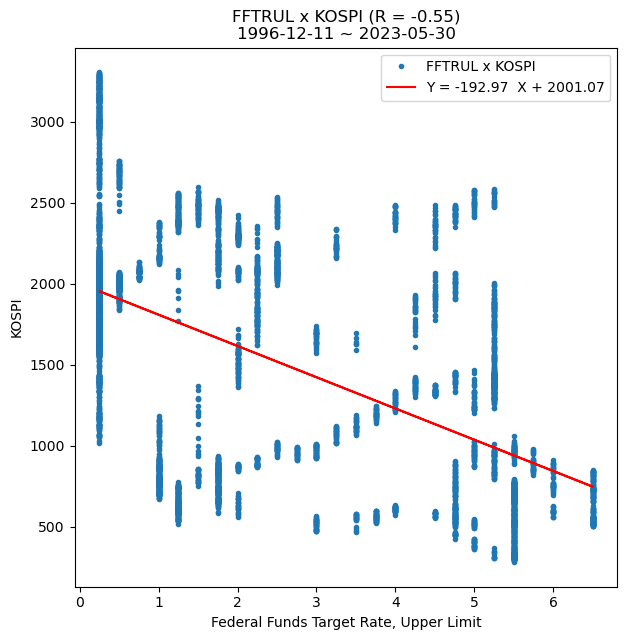

Federal Funds Target Rate, Upper Limit와 KOSPI의 회귀 그래프를 경로: /mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Analyze/Regression에 저장하였습니다.


In [151]:
Regression('FFTRUL')

[*********************100%***********************]  1 of 1 completed


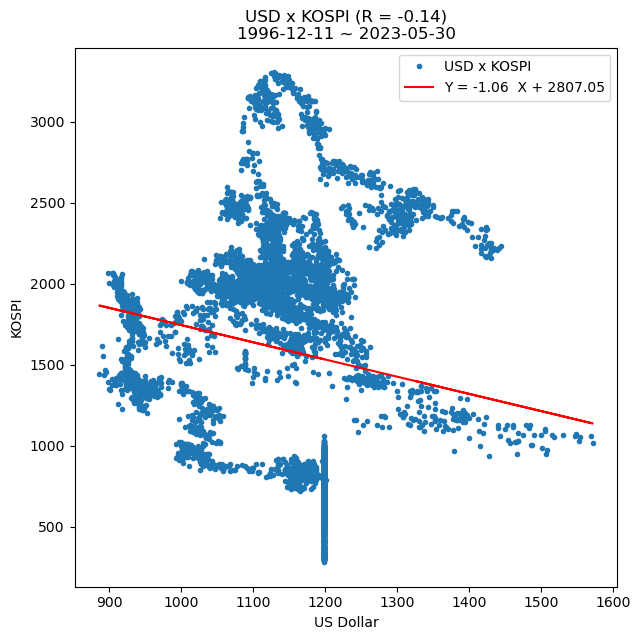

US Dollar와 KOSPI의 회귀 그래프를 경로: /mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Analyze/Regression에 저장하였습니다.


In [155]:
""" '^DJI': 'DOW Jones Industrial Average',
    'DX-Y.NYB': 'US Dollar Index',
    'KRW=X"""

Regression('KRW=X')

## 2. 인터넷에서 데이터를 다운로드 받자

In [3]:
!ls

 DowKospi_Regr.png
 FEDrateCrawler.ipynb
 FREDFederalFundsTargetRangeUpperLimit2008121620230520.csv
'Federal Funds Target Rate, Upper Limit 2023-05-21 11 21 35.xlsx'
 KospiRegr.py
 USDKospi_Regr.png
 USDXKospi_Regr.png
 __pycache__


In [15]:
import pandas as pd

FFTRUL = pd.read_excel('./Federal Funds Target Rate, Upper Limit 2023-05-21 11 21 35.xlsx', header=4)
FFTRUL

,Date,Value,YOY (%)
0,2008-12-16,0.25,NaN
1,2008-12-17,0.25,NaN
2,2008-12-18,0.25,NaN
3,2008-12-19,0.25,NaN
4,2008-12-20,0.25,NaN
...,...,...,...
5264,2023-05-16,5.25,2000.0
5265,2023-05-17,5.25,2000.0
5266,2023-05-18,5.25,2000.0
5267,2023-05-19,5.25,2000.0


In [16]:
FFTRUL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     5269 non-null   object 
 1   Value    5269 non-null   float64
 2   YOY (%)  4904 non-null   float64
dtypes: float64(2), object(1)
memory usage: 123.6+ KB


In [19]:
FFTRUL.isnull().sum()

Date     0
Value    0
dtype: int64

In [18]:
# 불필요한 컬럼 삭제
FFTRUL.drop('YOY (%)', axis=1, inplace=True)
FFTRUL

,Date,Value
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-20,0.25


### 야후 파이낸스에서 가져올 KOSPI 주가와 비교해야 하기 때문에, 먼저 가져와서 데이터의 사이즈를 확인하자

In [61]:
import pandas as pd
from pandas_datareader import data as pdr # 데이터 로딩 및 시각화를 위한 라이브러리
import yfinance as yf # 금융 데이터 가져오는 Yahoo Finance
yf.pdr_override() # 둘이 합체!
from scipy import stats # 회귀 분석을 위한 수학, 과학, 엔지니어링용 핵심 패키지 모음(넘파이 기반)
import matplotlib.pylab as plt # 그래프 출력
from datetime import datetime
import os

kospi = pdr.get_data_yahoo('^KS11', '2008-12-16')
kospi

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-12-16,1148.680054,1165.290039,1137.050049,1161.560059,1161.560059,626700
2008-12-17,1190.089966,1196.369995,1146.040039,1169.750000,1169.750000,647800
2008-12-18,1183.380005,1189.829956,1164.599976,1175.910034,1175.910034,557800
2008-12-19,1174.239990,1194.520020,1171.380005,1180.969971,1180.969971,685000
2008-12-22,1189.849976,1201.140015,1167.630005,1179.609985,1179.609985,450600
...,...,...,...,...,...,...
2023-05-15,2469.800049,2479.350098,2455.989990,2479.350098,2479.350098,483300
2023-05-16,2494.399902,2498.540039,2474.899902,2480.239990,2480.239990,627900
2023-05-17,2479.649902,2498.370117,2475.020020,2494.659912,2494.659912,563300


In [88]:
kospi = kospi.reset_index(drop=False) # 병합하기 위해 인덱스로 들어간 날짜를 컬럼으로 빼기
kospi

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-12-16,1148.680054,1165.290039,1137.050049,1161.560059,1161.560059,626700
1,2008-12-17,1190.089966,1196.369995,1146.040039,1169.750000,1169.750000,647800
2,2008-12-18,1183.380005,1189.829956,1164.599976,1175.910034,1175.910034,557800
3,2008-12-19,1174.239990,1194.520020,1171.380005,1180.969971,1180.969971,685000
4,2008-12-22,1189.849976,1201.140015,1167.630005,1179.609985,1179.609985,450600
...,...,...,...,...,...,...,...
3556,2023-05-15,2469.800049,2479.350098,2455.989990,2479.350098,2479.350098,483300
3557,2023-05-16,2494.399902,2498.540039,2474.899902,2480.239990,2480.239990,627900
3558,2023-05-17,2479.649902,2498.370117,2475.020020,2494.659912,2494.659912,563300
3559,2023-05-18,2511.090088,2515.399902,2500.010010,2515.399902,2515.399902,571500


In [90]:
kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3561 non-null   datetime64[ns]
 1   Open       3561 non-null   float64       
 2   High       3561 non-null   float64       
 3   Low        3561 non-null   float64       
 4   Close      3561 non-null   float64       
 5   Adj Close  3561 non-null   float64       
 6   Volume     3561 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 194.9 KB


### kospi DF 3561행 vs. FFTRUL DF 5269행
### kospi의 날짜 기준으로 맞추자

In [45]:
print(type(kospi.loc[0, 'Date']))
print(type(FFTRUL.loc[0, 'Date']))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'str'>


### Timestamp와 str은 병합(merge)이 안 되므로, 먼저 타입을 통일하자

In [52]:
kospi['Date'] = kospi['Date'].astype(str)

<class 'str'>


In [53]:
KOSPIFFTRUL = pd.merge(kospi, FFTRUL, how = 'left', left_on = 'Date', right_on = 'Date') # 날짜 교집합만 남기기 위해 kospi DF 기준으로 병합
# KOSPIFFTRUL = pd.concat([kospi, FFTRUL], axis=1, join='inner')

KOSPIFFTRUL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3560
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3561 non-null   object 
 1   Open       3561 non-null   float64
 2   High       3561 non-null   float64
 3   Low        3561 non-null   float64
 4   Close      3561 non-null   float64
 5   Adj Close  3561 non-null   float64
 6   Volume     3561 non-null   int64  
 7   Value      3561 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 250.4+ KB


In [57]:
FFTRUL = KOSPIFFTRUL[['Date', 'Value']] # 필요한 컬럼들만 가져오기
FFTRUL

,Date,Value
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-22,0.25
...,...,...
3556,2023-05-15,5.25
3557,2023-05-16,5.25
3558,2023-05-17,5.25
3559,2023-05-18,5.25


### kospi DF의 날짜가 인덱스로 들어가 있으므로, FFTRUL도 똑같이 만들어 주자

In [93]:
# Date 컬럼의 타입인 str을 Timestamp 타입으로 바꿔주고 인덱스로 빼기
FFTRUL['Date'] = pd.to_datetime(FFTRUL['Date']) # 'pandas._libs.tslibs.timestamps.Timestamp'
print(type(FFTRUL.loc[0, 'Date'])) # datetime64[ns]
FFTRUL.info()
FFTRUL.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3561 non-null   datetime64[ns]
 1   Value   3561 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 55.8 KB


,Date,Value
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-22,0.25


In [94]:
FFTRUL.set_index('Date', inplace=True)
FFTRUL

,Value
Date,
2008-12-16,0.25
2008-12-17,0.25
2008-12-18,0.25
2008-12-19,0.25
2008-12-22,0.25
...,...
2023-05-15,5.25
2023-05-16,5.25
2023-05-17,5.25


In [95]:
import pandas as pd
from pandas_datareader import data as pdr # 데이터 로딩 및 시각화를 위한 라이브러리
import yfinance as yf # 금융 데이터 가져오는 Yahoo Finance
yf.pdr_override() # 둘이 합체!
from scipy import stats # 회귀 분석을 위한 수학, 과학, 엔지니어링용 핵심 패키지 모음(넘파이 기반)
import matplotlib.pylab as plt # 그래프 출력
from datetime import datetime, timedelta
import os

# kospi = pdr.get_data_yahoo('^KS11', '2000-01-04') # KOSPI, 2000-01-04~
kospi = pdr.get_data_yahoo('^KS11', '2008-12-16') # KOSPI, 2008-12-16~
# today = datetime.now().date() # 오늘 날짜
# today = '2023-05-20'
today = datetime.now().date() - timedelta(days=1)
workspace = os.getcwd() # 현재 작업 경로 확인

# Tickers on Yahoo Finance
symbols = {
    '^DJI': 'DOW Jones Industrial Average',
    'DX-Y.NYB': 'US Dollar Index',
    'KRW=X': 'US Dollar',
    'FFTRUL': 'Federal Funds Target Rate, Upper Limit',
}

def Regression(opponent:str='^DJI', filepath:str=workspace): # Regression 함수 선언
    """다우존스 지수/달러 인덱스/달러와 KOSPI 지수 사이의 상관관계를 확인하기 위한 회귀 그래프를 그려주는 함수\n
    opponent='종목 티커', filepath='그래프를 저장할 경로'를 매개변수로 받음"""
    if opponent == 'FFTRUL':
        versus = FFTRUL
        df = pd.DataFrame({'X':versus['Value'], 'Y':kospi['Close']}) # 가로축 독립변수 x: 다우존스 지수, 세로축 종속변수 y: KOSPI 지수
    else: 
        versus = pdr.get_data_yahoo(opponent, '2008-12-16')
        df = pd.DataFrame({'X':versus['Close'], 'Y':kospi['Close']}) # 가로축 독립변수 x: 다우존스 지수, 세로축 종속변수 y: KOSPI 지수

    df = df.fillna(method='bfill') # 뒤의 값으로 결측치 대체
    df = df.fillna(method='ffill') # 마지막 행의 결측치를 앞의 값으로 대체

    regr = stats.linregress(df.X, df.Y) # 선형 회귀 모델 생성
    regr_line = f'Y = {regr.slope:.2f}  X + {regr.intercept:.2f}' # y의 기대치를 나타내는 회귀식. slope: 기울기, intercept: 절편

    plt.figure(figsize=(7, 7)) # 그래프 사이즈
    plt.plot(df.X, df.Y, '.') # X/Y의 좌표를 .으로 찍음 (Scatter Plot, 산점도)
    plt.plot(df.X, regr.slope * df.X + regr.intercept, 'r') # 회귀선을 붉은 선으로 그림
    
    plt.ylabel('KOSPI') # Y축은 KOSPI

    if opponent == '^DJI': # 다우존스 지수와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 DOW
        plt.legend(['DOW x KOSPI', regr_line]) # 범례
        # R 결정계수(상관계수의 제곱): 추정된 회귀선이 변수 사이의 관계를 얼마나 잘 설명하는지. 0 ~ 1
        plt.title(f'DOW x KOSPI (R = {regr.rvalue:.2f})\n2008-12-16 ~ {today}') # 그래프 제목
        plt.savefig(f'{filepath}/DowKospi_Regr.png', format="png", dpi=150) # 그래프 저장. dpi는 해상도

    elif opponent == 'DX-Y.NYB': # 달러 인덱스와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 USDX
        plt.legend(['USDX x KOSPI', regr_line])
        plt.title(f'USDX x KOSPI (R = {regr.rvalue:.2f})\n2008-12-16 ~ {today}')
        plt.savefig(f'{filepath}/USDXKospi_Regr.png', format="png", dpi=150)

    elif opponent == 'KRW=X': # 달러와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 USD
        plt.legend(['USD x KOSPI', regr_line])
        plt.title(f'USD x KOSPI (R = {regr.rvalue:.2f})\n2008-12-16 ~ {today}')
        plt.savefig(f'{filepath}/USDKospi_Regr.png', format="png", dpi=150)

    elif opponent == 'FFTRUL': # FFTRUL와 KOSPI 지수를 비교하고 싶다면
        plt.xlabel(symbols[opponent]) # X축은 FFTRUL
        plt.legend(['FFTRUL x KOSPI', regr_line])
        plt.title(f'FFTRUL x KOSPI (R = {regr.rvalue:.2f})\n2008-12-16 ~ {today}')
        plt.savefig(f'{filepath}/FFTRULKospi_Regr.png', format="png", dpi=150)

    plt.show() # 그래프 그리기
    print(f'{symbols[opponent]}와 KOSPI의 회귀 그래프를 경로: {filepath}에 저장하였습니다.')

[*********************100%***********************]  1 of 1 completed


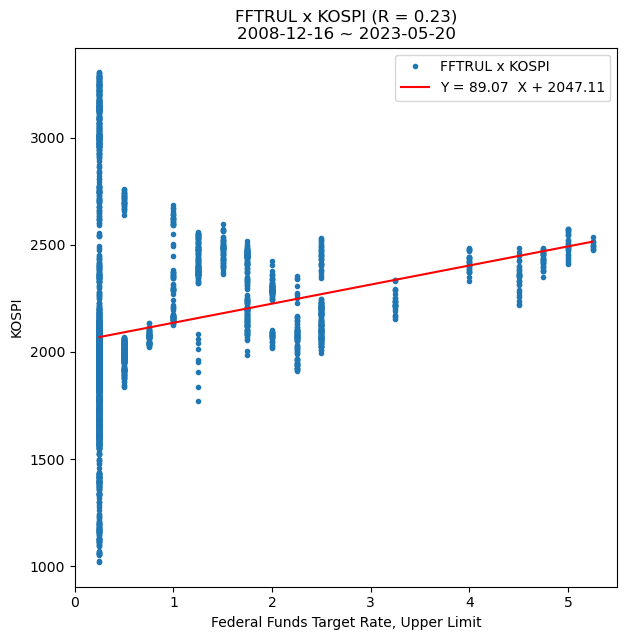

Federal Funds Target Rate, Upper Limit와 KOSPI의 회귀 그래프를 경로: /mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Analyze/Regression에 저장하였습니다.


In [96]:
Regression('FFTRUL')

[*********************100%***********************]  1 of 1 completed


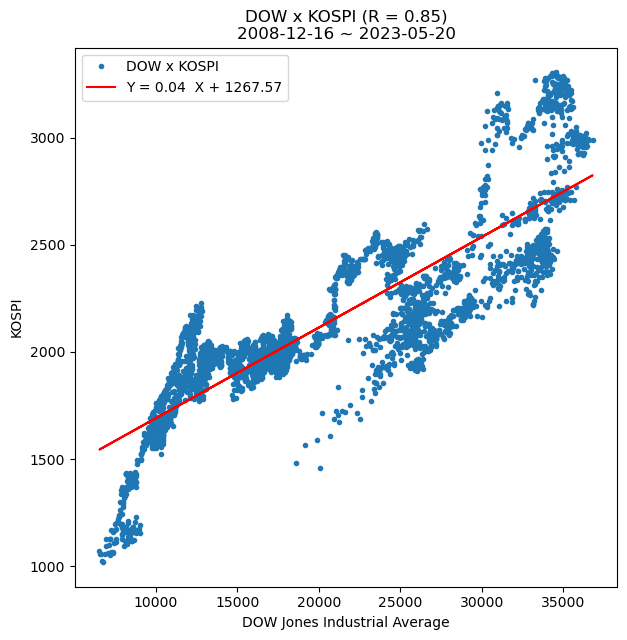

DOW Jones Industrial Average와 KOSPI의 회귀 그래프를 경로: /mnt/FE0A5E240A5DDA6B/workspace/jeon2_package/Analyze/Regression에 저장하였습니다.


In [97]:
Regression('^DJI')